In [1]:
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, BooleanType

In [2]:
import string
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[9]') \
    .config("spark.driver.memory", "15g") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .getOrCreate()

### Load and clean data

In [4]:
# årets hack

#df = spark.read.format("csv").option("delimiter",";").load("/data/shared1/bigrams/part5/2-00560-of-00589")

folders = ["/data/shared1/bigrams/part1", "/data/shared1/bigrams/part2", "/data/shared1/bigrams/part3",
           "/data/shared1/bigrams/part4", "/data/shared1/bigrams/part5", "/data/shared1/bigrams/part6",
           "/data/shared1/bigrams/Part1", "/data/shared1/bigrams/Part2", "/data/shared1/bigrams/Part3",
           "/data/shared1/bigrams/Part4"]

df = spark.read.format("csv").option("delimiter",";").load(folders)

for i in range(0, 500):
    df = df.withColumn('c'+str(i),split("_c0","\t").getItem(i))
    
df = df.drop('_c0')

In [5]:
def to_long(df, by):

    # Filter dtypes and split into column names and type description
    cols, dtypes = zip(*((c, t) for (c, t) in df.dtypes if c not in by))
    
    # Spark SQL supports only homogeneous columns
    assert len(set(dtypes)) == 1, "All columns have to be of the same type"

    # Create and explode an array of (column_name, column_value) structs
    kvs = explode(array([
      struct(lit(c).alias("key"), col(c).alias("val")) for c in cols
    ])).alias("kvs")

    return df.select(by + [kvs]).select(by + ["kvs.key", "kvs.val"])

In [6]:
def transform(df):
    split_col = pyspark.sql.functions.split(df['val'], ',')
    df = df.withColumn('year', split_col.getItem(0))
    df = df.withColumn('count', split_col.getItem(1))
    df = df.withColumn('volume', split_col.getItem(2))

    df = df.withColumnRenamed('c0', 'bigram')
    
    split_pos = pyspark.sql.functions.split(df['bigram'], ' ')
    df = df.withColumn('bigram1', split_pos.getItem(0))
    df = df.withColumn('bigram2', split_pos.getItem(1))

    split_bigram1 = pyspark.sql.functions.split(df['bigram1'], '_')
    df = df.withColumn('POS1', split_bigram1.getItem(1))
    split_bigram2 = pyspark.sql.functions.split(df['bigram2'], '_')
    df = df.withColumn('POS2', split_bigram2.getItem(1))

    df = df.withColumn('year', df['year'].cast('int'))
    df = df.withColumn('count', df['count'].cast('int'))
    
    df = df.drop('val')
    df = df.drop('key')
    df = df.drop('bigram1', 'bigram2')
    df = df.drop('volume')
    
    df = df.where(df['year'] >= 1900)
    
    return df

In [7]:
df_long = to_long(df, ["c0"])
df_long = df_long.dropna()

In [8]:
df = transform(df_long)

In [9]:
is_ascii = udf(lambda x: x.isascii(), BooleanType())
df = df.where(is_ascii(df.bigram))

df = df.where(~df.bigram.contains('_NUM'))
df = df.where(col('POS1').isNotNull() & col('POS2').isNotNull())

df = df.withColumn('bigram', lower(col('bigram')))

df = df.withColumn('POS', array('POS1', 'POS2'))

In [10]:
POSdf = df.groupBy('POS').agg(F.countDistinct('bigram').alias('POS_count'))

### Convert to pandas, clean and plot

In [11]:
POSdf_pd = POSdf.toPandas()

In [12]:
POSdf_pd['POS'] = POSdf_pd['POS'].astype(str)

In [13]:
splitpos = POSdf_pd['POS'].str.split(expand=True)
POSdf_pd['POS1'] = splitpos[0]
POSdf_pd['POS2'] = splitpos[1]

In [14]:
POSdf_pd['relevant_tag'] = (POSdf_pd['POS1'].str.contains('ADV|NOUN|VERB|ADJ|PRON|DET|ADP|CONJ|PRT') &
                            POSdf_pd['POS2'].str.contains('ADV|NOUN|VERB|ADJ|PRON|DET|ADP|CONJ|PRT'))

In [15]:
POSdf_pd = POSdf_pd[POSdf_pd['relevant_tag']]
POSdf_pd = POSdf_pd.drop(['relevant_tag', 'POS1', 'POS2'], 1)

In [16]:
POSdf_pd['percent'] = (POSdf_pd['POS_count']/POSdf_pd['POS_count'].sum()) * 100
POSdf_pd = POSdf_pd.sort_values('percent',ascending=False)

In [17]:
plotdf = POSdf_pd
plotdf = plotdf[plotdf.percent >= 0.1]

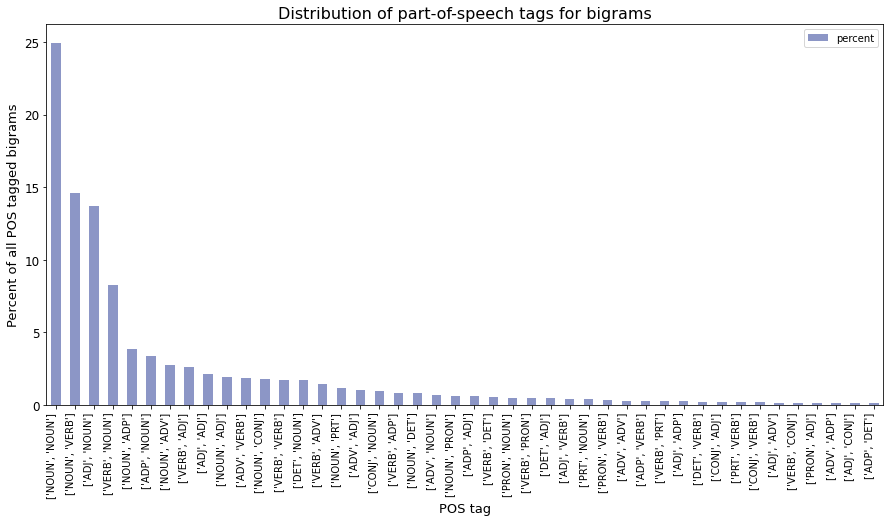

In [18]:
plotdf.plot(x='POS', y='percent', kind='bar',figsize=(15,7),color = '#8c96c6')
plt.xlabel("POS tag", fontsize = 13)
plt.ylabel("Percent of all POS tagged bigrams", fontsize = 13)
plt.title("Distribution of part-of-speech tags for bigrams", fontsize = 16)
plt.tick_params(labelsize=12);
plt.xticks(
    rotation=90,
    horizontalalignment='right',
    fontsize='medium',
)
plt.show()